In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


In [163]:
import  numpy as np
import pandas as pd
import optuna
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [164]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#KNN

In [165]:
class KNearestNeighbors:
    def __init__(
        self,
        metrics: str = "manhattan",
        p: int = 3,
        kernel: str = "gaussian",
        window: str = "fixed",
        k: int = 2,
        h: float = 2
    ):
        self.priori_weights = None
        self.classes = None
        self.X_train = None
        self.y_train = None
        self.posterior_weights = {}
        self.window = window
        self.k = k
        self.h = h
        self.p = p
        all_metrics = {
            'manhattan': lambda x, y: np.max(np.abs(x - y)),
            'euclidean': lambda x, y: np.sqrt(np.sum((x - y) ** 2)),
            'chebyshev': lambda x, y: np.max(np.abs(x - y)),
            'minkowski': lambda x, y: (np.sum((x - y) ** self.p)) ** (1 / self.p),
            'cos': lambda x, y: 1 - np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        }
        all_kernels = {
            'uniform': lambda u: 0.5 if abs(u) < 1 else 0,
            'triangular': lambda u: max(0, 1 - abs(u)),
            'epanechnikov': lambda u: max(0, 0.75 * (1 - u ** 2)),
            'gaussian': lambda u: np.exp(u ** 2 / -2) / np.sqrt(2 * np.pi)
        }
        self.metric = all_metrics[metrics]
        self.kernel_name = kernel
        self.kernel = all_kernels[kernel]
        self.nn = NearestNeighbors(metric=self.metric)

    def fit(self, X_train, y_train, priori_weights = None):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = list(set(self.y_train))
        self.nn.fit(X_train)
        if priori_weights:
            self.priori_weights = priori_weights
        else:
            self.priori_weights = np.ones(len(self.y_train)).tolist()

        for cl in self.classes:
            self.posterior_weights[cl] = 0

        return self


    def predict(self, X_test):
        y_pred = []
        if self.window == "fixed":
            dist, n = self.nn.radius_neighbors(X_test, radius=self.h)
        else:
            dist, n = self.nn.kneighbors(X_test, n_neighbors=self.k)
            self.h = dist[-1][-1]
        y = []
        posterior_weights = []
        for i in range(len(X_test)):
            assert n[i].size != 0, "h is too small for index"
            for index in n[i]:
                y.append(self.y_train[index])
                posterior_weights.append(self.priori_weights[index])

            for d, cl, pw in zip(dist[i], y, posterior_weights):
                self.posterior_weights[cl] += self.kernel(d / self.h) * pw

            y_pred.append(max(self.posterior_weights, key = self.posterior_weights.get))

        return y_pred


In [166]:
def lowess(x_df, y_df):
    weights = []
    for i in tqdm(range(x_df.shape[0])):
        x_test = x_df[i]
        y_test = y_df[i]
        x_train = np.delete(x_df, i, axis=0)
        y_train = np.delete(y_df, i, axis=0)
        model = KNearestNeighbors(
            metrics='manhattan',
            k=3,
            kernel='triangular',
            window='mutable'
        ).fit(x_train, y_train)
        y_pred = model.predict(x_test.reshape(1, -1))
        a = max(0, 1 - abs(y_test - y_pred))
        weights.append(a if isinstance(a, int) or isinstance(a, float) else a[0])
    return weights

In [167]:
optuna.logging.set_verbosity(optuna.logging.WARN)


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

##test

In [168]:
samples = np.array([[0, 0, 2], [1, 0, 0], [0, 0, 1]])
y_train = np.array(['men', 'women', 'men'])

knn = KNearestNeighbors(window="p", kernel='epanechnikov', p = 2).fit(samples, y_train)

x_test = np.array([[0, 0, 1.3], [0, 0, 0.1],  [1.1, 0, 0]])
y_pred = knn.predict(x_test)
print(y_pred)


['men', 'men', 'men']


#Prediction My DF

In [169]:
df_x = pd.read_csv('/content/drive/MyDrive/study/andan/df_main.csv', index_col=0)
df_target = pd.read_csv('/content/drive/MyDrive/study/andan/df_target.csv', index_col=0)

In [170]:
df_target_men = df_target[df_target['class'] == 2]
df_target_women = df_target[df_target['class'] == 1]

df_target_lowest_men = df_target_men.sample(1000)
df_target_lowest_women = df_target_women.sample(1000)
df_x_lowest_men = df_x.loc[df_target_lowest_men.index]
df_x_lowest_women = df_x.loc[df_target_lowest_women.index]
df_x_low = pd.concat([df_x_lowest_women, df_x_lowest_men])
df_y_low = pd.concat([df_target_lowest_women, df_target_lowest_men])


In [ ]:
# cols = df_x_low.columns
# cols_to_drop = []
# for col in cols:
#     if df_x_low[df_x_low[col] < 0.000001].shape[0] / 2000 > 0.8:
#         cols_to_drop.append(col)
# len(cols_to_drop)

1073

In [171]:
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(df_x_low)
pca.explained_variance_ratio_

array([0.05849021, 0.0517575 , 0.04041569, 0.03636858, 0.02949738,
       0.02719798, 0.02429308, 0.02135241, 0.01935656, 0.01876039,
       0.01576215, 0.01518706, 0.01472713, 0.01375478, 0.01274433,
       0.0119994 , 0.01170874, 0.01109376, 0.0109571 , 0.01057701])

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, df_y_low, test_size=0.3, random_state=42)

In [173]:
y_test_l = y_test['class'].to_list()
y_train_l = y_train['class'].to_list()


test

In [175]:
model = KNearestNeighbors(
    metrics='manhattan',
    h=3,
    kernel='triangular',
    window='fixed'
).fit(X_train, y_train_l)
y_pred = model.predict(X_test)
accuracy_score(y_test_l, y_pred)

0.505

optimization

In [177]:
X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train_l, test_size=0.2, random_state=42)
def objective_fixed(trial):
    y_pred = KNearestNeighbors(
        metrics=trial.suggest_categorical('metrics', ['manhattan', "euclidean", 'chebyshev', 'cos']),
        h=trial.suggest_int("h", 3, 20),
        kernel=trial.suggest_categorical('kernel', ['uniform', "triangular", 'epanechnikov', 'gaussian']),
        window='fixed'
    ).fit(X_train_v, y_train_v).predict(X_valid)

    return accuracy_score(y_valid, y_pred)

def objective_mut(trial):
    y_pred = KNearestNeighbors(
        metrics=trial.suggest_categorical('metrics', ['manhattan', "euclidean", 'chebyshev', 'cos']),
        k=trial.suggest_int("k", 1, 101),
        kernel=trial.suggest_categorical('kernel', ['uniform', "triangular", 'epanechnikov', 'gaussian']),
        window='mu'
    ).fit(X_train_v, y_train_v).predict(X_valid)

    return accuracy_score(y_valid, y_pred)

study_fixed = optuna.create_study(direction="maximize")
study_fixed.optimize(objective_fixed, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

study_mut = optuna.create_study(direction="maximize")
study_mut.optimize(objective_mut, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.4785714285714286 and parameters: {'metrics': 'manhattan', 'h': 20, 'kernel': 'triangular'}. 
Trial 4 finished with best value: 0.55 and parameters: {'metrics': 'euclidean', 'h': 5, 'kernel': 'epanechnikov'}. 


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.5214285714285715 and parameters: {'metrics': 'euclidean', 'k': 83, 'kernel': 'uniform'}. 


for fixed window

In [178]:
print(study_fixed.best_params)
print(study_fixed.best_value)

{'metrics': 'euclidean', 'h': 5, 'kernel': 'epanechnikov'}
0.55


for mut window

In [179]:
print(study_mut.best_params)
print(study_mut.best_value)

{'metrics': 'euclidean', 'k': 83, 'kernel': 'uniform'}
0.5214285714285715


Accuracy neigbors dependence

  0%|          | 0/18 [00:00<?, ?it/s]

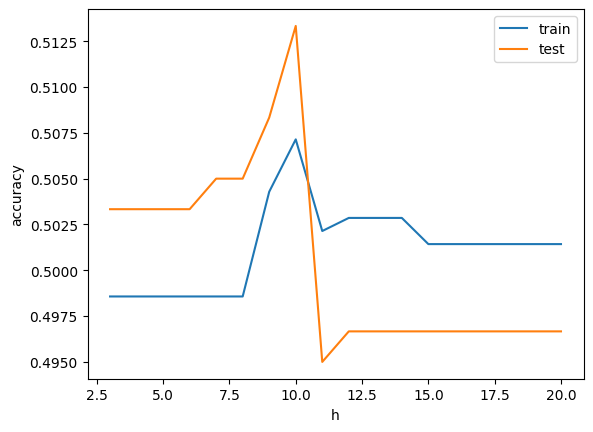

In [180]:
test_acc_depens_k = []
traint_acc_depens_k = []
for i in tqdm(range(3, 21)):
    model = KNearestNeighbors(
        metrics='euclidean',
        h=i,
        kernel='epanechnikov',
        window='fixed'
    ).fit(X_train, y_train_l)
    y_pred_test = model.predict(X_test)
    test_acc_depens_k.append(accuracy_score(y_test_l, y_pred_test))
    model = KNearestNeighbors(
        metrics='euclidean',
        h=i,
        kernel='epanechnikov',
        window='fixed'
    ).fit(X_train, y_train_l)
    y_pred_train = model.predict(X_train)
    traint_acc_depens_k.append(accuracy_score(y_train_l, y_pred_train))


plt.plot(range(3, 21), traint_acc_depens_k, label='train')
plt.plot(range(3, 21), test_acc_depens_k, label='test')
plt.legend()
plt.xlabel('h')
plt.ylabel('accuracy')
plt.show()

Lowess

In [181]:
priori_weights = lowess(X_train, np.array(y_train_l))

model = KNearestNeighbors(
        metrics='euclidean',
        h=5,
        kernel='epanechnikov',
        window='fixed',
).fit(X_train, y_train_l, priori_weights=priori_weights)
y_pred = model.predict(X_test)
print('weighted: ')
accuracy_score(y_test_l, y_pred)

  0%|          | 0/1400 [00:00<?, ?it/s]

weighted: 


0.5033333333333333

no weights

In [182]:
model = KNearestNeighbors(
        metrics='euclidean',
        h=5,
        kernel='epanechnikov',
        window='fixed',
).fit(X_train, y_train_l)
y_pred = model.predict(X_test)
print('unweighted: ')
accuracy_score(y_test_l, y_pred)

unweighted: 


0.5033333333333333

# Prediction kagle

In [183]:
df = pd.read_csv('/content/drive/MyDrive/study/andan/pima-indians-diabetes.csv', header=None)

target = df[8]
df_x = df.drop([8], axis=1)
df_x

,0,1,2,3,4,5,6,7
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [184]:
# минмакс
def normalize(x):
    return [round((i - min(x)) / (max(x) - min(x)), 4) for i in x]

for col in df_x.columns:
    df_x[col] = normalize(df_x[col].to_list())

df_x

,0,1,2,3,4,5,6,7
0,0.3529,0.7437,0.5902,0.3535,0.0000,0.5007,0.2344,0.4833
1,0.0588,0.4271,0.5410,0.2929,0.0000,0.3964,0.1166,0.1667
2,0.4706,0.9196,0.5246,0.0000,0.0000,0.3472,0.2536,0.1833
3,0.0588,0.4472,0.5410,0.2323,0.1111,0.4188,0.0380,0.0000
4,0.0000,0.6884,0.3279,0.3535,0.1986,0.6423,0.9436,0.2000
...,...,...,...,...,...,...,...,...
763,0.5882,0.5075,0.6230,0.4848,0.2128,0.4903,0.0397,0.7000
764,0.1176,0.6131,0.5738,0.2727,0.0000,0.5484,0.1119,0.1000
765,0.2941,0.6080,0.5902,0.2323,0.1324,0.3905,0.0713,0.1500
766,0.0588,0.6332,0.4918,0.0000,0.0000,0.4486,0.1157,0.4333


In [185]:
X_train, X_test, y_train, y_test = train_test_split(df_x, target, test_size=0.3, random_state=42)

In [186]:
model = KNearestNeighbors(
    metrics='manhattan',
    k=5,
    kernel='triangular',
    window='mut'
).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = model.predict(X_test.to_numpy())
accuracy_score(y_test.to_numpy(), y_pred)

0.6536796536796536

In [187]:
X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective_fixed(trial):
    y_pred = KNearestNeighbors(
        metrics=trial.suggest_categorical('metrics', ['manhattan', "euclidean", 'chebyshev', 'cos']),
        h=trial.suggest_int("h", 1, 20),
        kernel=trial.suggest_categorical('kernel', ['uniform', "triangular", 'epanechnikov', 'gaussian']),
        window='fixed'
    ).fit(X_train_v.to_numpy(), y_train_v.to_numpy()).predict(X_valid.to_numpy())

    return accuracy_score(y_valid.to_numpy(), y_pred)

def objective_mut(trial):
    y_pred = KNearestNeighbors(
        metrics=trial.suggest_categorical('metrics', ['manhattan', "euclidean", 'chebyshev', 'cos']),
        k=trial.suggest_int("k", 1, 101),
        kernel=trial.suggest_categorical('kernel', ['uniform', "triangular", 'epanechnikov', 'gaussian']),
        window='mu'
    ).fit(X_train_v.to_numpy(), y_train_v.to_numpy()).predict(X_valid.to_numpy())

    return accuracy_score(y_valid.to_numpy(), y_pred)

study_fixed = optuna.create_study(direction="maximize")
study_fixed.optimize(objective_fixed, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

study_mut = optuna.create_study(direction="maximize")
study_mut.optimize(objective_mut, n_trials=100, show_progress_bar=True, callbacks=[logging_callback])

  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.6388888888888888 and parameters: {'metrics': 'cos', 'h': 4, 'kernel': 'gaussian'}. 


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.6388888888888888 and parameters: {'metrics': 'euclidean', 'k': 70, 'kernel': 'uniform'}. 


In [189]:
from sklearn.neighbors import KNeighborsClassifier
def objective(trial):
    pred = KNeighborsClassifier(
        n_neighbors=trial.suggest_int("k", 1, 100),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical('metric', ['manhattan', 'euclidean', 'cosine'])
    ).fit(X_train.to_numpy(), y_train.to_numpy()).predict(X_test.to_numpy())
    return accuracy_score(y_test.to_numpy(), y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True, callbacks=[logging_callback])

  0%|          | 0/200 [00:00<?, ?it/s]

Trial 0 finished with best value: 0.6536796536796536 and parameters: {'k': 13, 'weights': 'uniform', 'metric': 'euclidean'}. 


In [190]:
test_acc_depens_k = []
traint_acc_depens_k = []
for i in tqdm(range(1, 101)):
    model = KNearestNeighbors(
        metrics='euclidean',
        k=i,
        kernel='uniform',
        window='mutable'
    ).fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred_test = model.predict(X_test.to_numpy())
    test_acc_depens_k.append(accuracy_score(y_test.to_numpy(), y_pred_test))
    model = KNearestNeighbors(
        metrics='euclidean',
        k=i,
        kernel='uniform',
        window='mutable'
    ).fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred_train = model.predict(X_train.to_numpy())
    traint_acc_depens_k.append(accuracy_score(y_train.to_numpy(), y_pred_train))

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-165-fff21572ad40>:70: RuntimeWarning: invalid value encountered in scalar divide
  self.posterior_weights[cl] += self.kernel(d / self.h) * pw


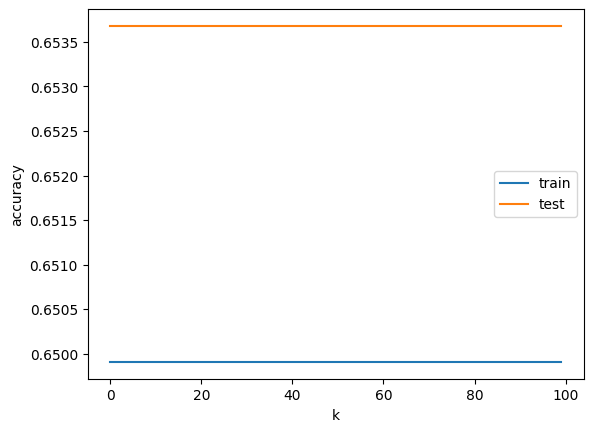

In [191]:
plt.plot(traint_acc_depens_k, label='train')
plt.plot(test_acc_depens_k, label='test')
plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

Lowess


In [192]:
priori_weights = lowess(X_train.to_numpy(), np.array(y_train_l))

model = KNearestNeighbors(
        metrics='manhattan',
        k=21,
        kernel='triangular',
        window='mutable',
).fit(X_train.to_numpy(), y_train.to_numpy(), priori_weights=priori_weights)
y_pred = model.predict(X_test.to_numpy())
print('weighted: ')
accuracy_score(y_test.to_numpy(), y_pred)

  0%|          | 0/537 [00:00<?, ?it/s]

weighted: 


0.6536796536796536

no weights


In [193]:
model = KNearestNeighbors(
        metrics='manhattan',
        k=21,
        kernel='triangular',
        window='mutable',
).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = model.predict(X_test.to_numpy())
print('unweighted: ')
accuracy_score(y_test.to_numpy(), y_pred)

unweighted: 


0.6536796536796536